In [89]:
# Importing the required libraries
import torch
from torch import nn
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
from IPython import display
import sys

batch_size = 128 # batch size

# Declaring the transformations to be applied to the train data
train_trans = transforms.Compose([ 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(32, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),
    transforms.ToTensor()
])

# Declaring the transformations to be applied to the test data (no transformations)
test_trans = transforms.Compose([
    transforms.ToTensor()
])

# getting the CIFAR10 train data
CIFAR10_train = torchvision.datasets.CIFAR10(
    root="../data", train=True, transform=train_trans,download=True)
# getting the CIFAR10 test data
CIFAR10_test = torchvision.datasets.CIFAR10(
    root="../data", train=False, transform=test_trans, download=True)


# creating the test dataloader which will return batch size number of data when called
test_iter = torch.utils.data.DataLoader(CIFAR10_test, batch_size, shuffle=False)
# creating the train dataloader which will return batch size number of data when called
train_iter = torch.utils.data.DataLoader(CIFAR10_train, batch_size, shuffle=True) # train data will be shuffled



Files already downloaded and verified
Files already downloaded and verified


In [90]:
# Chosing GPU if availabe
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [94]:
# This is the class for creating basic blocks used for building the model
class BASICBLOCK(nn.Module):
    # Constructor takes in as arguments the number of convolutional layers (k), input and output channel size of the layers, 
    # the resolution(size) of the image, a tuple containing parameters for the conv layers, and whether batch normalization will be applied to the block
    def __init__(self, num_convs, input_channels, output_channels, resolution, conv_params, applyBN1=False):
        super(BASICBLOCK,self).__init__()

        self.num_convs = num_convs
        self.applyBN1 = applyBN1 
        # Declearing the spatialAveragePooling function with the kernel size equal to the resolution of the image
        # so that there will be 1 value per channel
        self.spatial_pooling1 = nn.AvgPool2d(kernel_size=resolution, stride=1, padding=0)
        self.FLT = nn.Flatten() # Declaring flatten function
        # Declaring the linear layer for predicting the values of k coefficients, one for each conv layer
        self.linear1 = nn.Linear(in_features=input_channels, out_features=num_convs)
        self.Tanh = nn.Tanh() # Activation function Tanh
        
        # Creating the k convolutional layers with the same number of input, output channels and the appropriate kernel, padding, and stride as provided by the argument
        for i in range(0, self.num_convs):
            self.add_module('conv{num}'.format(num=i+1), nn.Conv2d(input_channels, output_channels, kernel_size=conv_params[0], padding=conv_params[1], stride=conv_params[2]))
        
        self.BN1 = nn.BatchNorm2d(output_channels) # Declaring the batch normalization function

    def forward(self, x):
        coefficients = self.spatial_pooling1(x) # Applying the spatialAveragePooling
        coefficients = self.FLT(coefficients) # Flattening the result
        coefficients = self.linear1(coefficients) # Passing it through the linear layer
        coefficients = self.Tanh(coefficients) # Applying the activation function

#         outputs = []
#         for i in range(0, self.num_convs):
#             outputs.append(self.relu((self._modules[f"conv{i+1}"](x))) * coefficients[:, i].unsqueeze(1).unsqueeze(2).unsqueeze(3))
            
#         o = sum(outputs)

        #checking if the batch normalization should be applied to this block
        if self.applyBN1:
            # here the multiplication between the output of each conv layer and the respective coefficient is performed
            # this is done through a list comprehension which loops through each conv layer and accesses the right coefficient
            # the coefficient is first made into the right dimension by using unsqueeze() before being multiplied with the output of the respective conv layer
            # the result of Multiplication is then passed through the activation function and is summed together using sum()
            
            o = sum([self.Tanh((self._modules['conv{num}'.format(num=i+1)](x))) * coefficients[:, i].unsqueeze(1).unsqueeze(2).unsqueeze(3) for i in range(self.num_convs-1)])
             # If the batch normalization is being applied, it is only applied to the last conv layer of the current block 
            o = o + self.Tanh(self.BN1(self._modules['conv{num}'.format(num=self.num_convs-1)](x))) * coefficients[:, self.num_convs - 1].unsqueeze(1).unsqueeze(2).unsqueeze(3)
            
        else:
            # Multiplication and summing without the application of batch normalization 
            o = sum([self.Tanh(self._modules['conv{num}'.format(num=i+1)](x)) * coefficients[:, i].unsqueeze(1).unsqueeze(2).unsqueeze(3) for i in range(self.num_convs)])
        
        
        
        return o

In [95]:
# This class creates the classifier of the model

class CLASSIFIER(torch.nn.Module):
    # Constructor takes as arguments the resolution of the image(size) and the number of channels of the data
    def __init__(self, resolution, input_channels):
        super(CLASSIFIER, self).__init__()

        # Declaring the spatialAveragePooling function with the kernel size equal to the resolution of the image
        # so that there will be 1 value per channel
        self.spatial_pooling2 = nn.AvgPool2d(kernel_size=resolution, padding=0, stride=1) 
        self.FLT = torch.nn.Flatten() # Declaring flatten function
        
        # Following lines declare a multi perceptron made of 3 layers where channels are decreased evenly through each layer
        self.linear1 = nn.Linear(input_channels, 64) 
        self.linear2 = nn.Linear(64, 32)
        # the last layer outputs exactly 10 channels as the images being classified will belong to 10 classes
        self.linear3 = nn.Linear(32, 10)
        self.Tanh = nn.Tanh() # activation function tanh

    def forward(self, x):
        # the following code first applies the spatialAveragePooling, flattens the output which is then fed through 
        # the multi perceptron. After each layer the activation function is applied
        out = self.spatial_pooling2(x)
        out = self.FLT(out)
        out = self.linear1(out)
        out = self.Tanh(out)
        out = self.linear2(out)
        out = self.Tanh(out) 
        out = self.linear3(out)

        return out

In [96]:
# This class declares the overall model using the BASICBLOCK and CLASSIFIER classes

class MODEL(nn.Module):
    def __init__(self):
        super(MODEL,self).__init__()
        
        # This model is composed of 4 blocks: the first 2 have 5 convolutional layers while the third block has 4 and the last, has only 3.
        # As the model goes from the starting block to the next ones the number of output channels are doubled at each stage. at the same time 
        # the resolution of the images is decreased from block to block. 
        # The first 3 blocks will have batch normalization be applied to their conv layers
        self.block1 = BASICBLOCK(num_convs=5, input_channels=3, output_channels=16, resolution=32, conv_params=[9, 0, 1],applyBN1=True)
        self.block2 = BASICBLOCK(num_convs=5, input_channels=16, output_channels=32, resolution=24, conv_params=[2, 3, 2],applyBN1=True)
        self.block3 = BASICBLOCK(num_convs=4, input_channels=32, output_channels=64, resolution=15, conv_params=[4, 0, 1],applyBN1=True)
        self.block4 = BASICBLOCK(num_convs=3, input_channels=64, output_channels=128, resolution=12, conv_params=[3, 0, 1],applyBN1=False)
        
        # the classifier takes the output of the last block. This has image resolution 10, and 128 channels
        self.classifier = CLASSIFIER(resolution=10, input_channels=128)

    def forward(self, x):
        
        # Here the input x is passed through the first block. The output of the first block will be passed into the second block and so on
        out = x
        out = self.block1(out)
        # print(out.shape)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        
        # Classifier takes the last output and returns the final prediction which be composed of 10 numbers(representing the 10 classes)
        # the predicted class will be the one with highest number
        out = self.classifier(out)
        return out




In [97]:
# Creating the model object
model = MODEL()

# Needed for GPU
model.to(device)

# Used to print total number of parameters used by the model
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Number of parameters: {total_params}")
     

Number of parameters: 394394


In [ ]:
# The following two cells contain code taken from previous labs and MU script file. 

In [98]:
#  Used to retain record of model training data about each epoch
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

d2l = sys.modules[__name__]

# This function returns the number of correction predictions in the batch given
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the one with the largest value therefore using argmax to check for the chosen one    
    cmp = (y_hat.type(y.dtype) == y)  # comparing predicted classes with the actual classes
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

# This function just calculates the test accuracy of the model as a percentage for 1 epoch
def evaluate_accuracy(net, data_iter): 
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter): # loops through epoch batch by batch
        X = X.to(device) # To make use of gpu
        y = y.to(device) # To make use of gpu
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1] # dividing correct predictions by the tot. number of prediction to find the percentage accuracy

    
# This is the script used to train the model for 1 epoch
def train_epoch_ch3(net, train_iter, loss, optimizer, batch_size=256, num_outputs=10):  
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter: # accessing the batches in the epoch(X data, y labels)
        # Compute gradients and update parameters
        X = X.to(device) # To make use of gpu
        y = y.to(device) # To make use of gpu
        y_hat = net(X) # passing the images (input) to the model and storing the predictions in y_hat
        l = loss(y_hat, y) # declaring the loss function by providing the predictions and the labels
        optimizer.zero_grad() # clearing gradients
        l.backward() # performing backward to compute gradients
        optimizer.step() # updates the parameters so as to reduce the error
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy by dividing by the batch size
    return metric[0] / metric[2], metric[1] / metric[2]


# This is the overall training function which trains the model through all the epochs and plots the graph 
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer):  
    
    # This is a class used to do the graph plotting. It plots the train loss, train accuracy and test accuracy on the same graph
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    # For each epoch
    for epoch in range(num_epochs):
        # train the model and return the training loss and accuracy
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        # Compute the test accuracy 
        test_acc = evaluate_accuracy(net, test_iter)
        # Update the graph by adding the new calculated model performance 
        animator.add(epoch + 1, train_metrics + (test_acc,))
        # If it's the last epoch print the test accuracy
        if epoch == num_epochs-1:
            print(f"Test Accuracy:{test_acc} ")

In [100]:
# The following code is just pytorch code used to do plotting (taken from MU file)
def use_svg_display():  
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')


    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [101]:
# Creating the loss function (in this case cross entropy)
loss = nn.CrossEntropyLoss()
wd = 0.0005 # weight decay hyperparameter
lr = 0.015 # learning rate hyperparamter
mm = 0.7 # momentum hyperparamter

# Creating the optimizer in this case using SGD, and passing in the hyperparamters
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=mm)

Test Accuracy:0.8042 


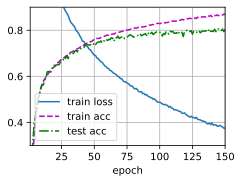

In [102]:
num_epochs = 150 # number of epochs the model will be trained for

# calling the training function by passing the model, training/testing data iterators, loss function, epochs number
# and optimizer
train_ch3(model, train_iter, test_iter, loss, num_epochs, optimizer)